In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Packages Loading

In [2]:
# import general necessary packages
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, cv2
# import the necessary packages -- cnn_regression
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from numpy.random import seed
from tensorflow import set_random_seed
from numpy import savez_compressed
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


### Data Loading

#### Image Data

In [0]:
# define images data file path
path = "/content/drive/My Drive/Spring 2020 Materials/Week 2/Weather Project/Cropped/"
train_dir = path + "Train/"
val_dir = path + "Validation/"
test_dir = path + "Test/"
result = path + "Model Results/"

In [0]:
'''
# load image train data
x_train_images = []
# make sure to read it in order
for image_path in sorted(os.listdir(train_dir)):
  img_path = train_dir + image_path
  image = cv2.imread(img_path)
  x_train_images.append(image)
x_train = np.array(x_train_images)'''

In [0]:
'''# load image validation data
x_val_images = []
# make sure to read it in order
for image_path in sorted(os.listdir(val_dir)):
  img_path = val_dir + image_path
  image = cv2.imread(img_path)
  x_val_images.append(image)
x_val = np.array(x_val_images)'''

In [0]:
'''# load image test data
x_test_images = []
# make sure to read it in order
for image_path in sorted(os.listdir(test_dir)):
  img_path = test_dir + image_path
  image = cv2.imread(img_path)
  x_test_images.append(image)
x_test = np.array(x_test_images)'''

In [0]:
'''# save loaded and converted image data 
savez_compressed(path+'train_data.npz', x_train)
savez_compressed(path+'val_data.npz', x_val)
savez_compressed(path+'test_data.npz', x_test)'''

In [0]:
# load image numpy array from npz file
from numpy import load
# load dict of arrays
train_data = load(path+'train_data.npz')
x_train = train_data['arr_0']
val_data = load(path+'val_data.npz')
x_val = val_data['arr_0']
test_data = load(path+'test_data.npz')
x_test = test_data['arr_0']

#### Weather Data

In [5]:
# import weather data
target_data = pd.read_csv("/content/drive/My Drive/Spring 2020 Materials/Week 2/Weather Project/Data/model_ready.csv")
target_data.head()

,valid,tmpf,drct,sknt
0,2016-09-01 00:00:00,75.02,222.500000,5.125000
1,2016-09-01 01:00:00,73.94,202.857143,4.857143
2,2016-09-01 02:00:00,73.94,218.181818,4.272727
3,2016-09-01 03:00:00,73.94,204.444444,4.555556
4,2016-09-01 04:00:00,73.04,145.000000,2.700000


In [6]:
# convert to a timedate
target_data['valid'] =  pd.to_datetime(target_data['valid'])
# set timedate to index
target_data = target_data.set_index('valid')
target_data.isna().sum()

tmpf    21
drct     7
sknt     3
dtype: int64

In [8]:
target_data[target_data.drct == 0]

,tmpf,drct,sknt
valid,,,
2016-09-01 15:00:00,69.98,0.0,0.0
2016-09-04 00:00:00,62.96,0.0,0.0
2016-09-10 06:00:00,73.04,0.0,0.0
2016-09-12 09:00:00,51.08,0.0,0.0
2016-09-13 06:00:00,55.04,0.0,0.0
...,...,...,...
2017-08-24 10:00:00,57.90,0.0,0.0
2017-08-26 10:00:00,51.10,0.0,0.0
2017-08-28 04:00:00,55.00,0.0,0.0


In [9]:
target_data = target_data.fillna(0)
target_data.head()

,tmpf,drct,sknt
valid,,,
2016-09-01 00:00:00,75.02,222.500000,5.125000
2016-09-01 01:00:00,73.94,202.857143,4.857143
2016-09-01 02:00:00,73.94,218.181818,4.272727
2016-09-01 03:00:00,73.94,204.444444,4.555556
2016-09-01 04:00:00,73.04,145.000000,2.700000


In [0]:
# fill the 0 with the past 5 hous mean
# tmpf column
for i in range(0,8719):
  if target_data.iloc[i][0] == 0:
    target_data['tmpf'].iloc[i] = total = target_data['tmpf'].iloc[i-5:i].mean()
# drct column
  if target_data.iloc[i][1] == 0:
    target_data['drct'].iloc[i] = total = target_data['drct'].iloc[i-5:i].mean()

In [17]:
target_data[target_data.drct == 0] # no 0s anymore

,tmpf,drct,sknt
valid,,,


In [0]:
# set train and test dataset
a = pd.Timestamp('2017/06/01 00:00:00')
b = pd.Timestamp('2017/08/01 00:00:00')
sample = target_data[target_data.index < b]
train = target_data[target_data.index < a]
val = sample[sample.index >= a]
test = target_data[target_data.index >= b]
# separate the data into train, validation and test
# tmpf model
y_train_1 = train['tmpf']
y_val_1 = val['tmpf']
y_test_1 = test['tmpf']
# drct model
y_train_2 = train['drct']
y_val_2 = val['drct']
y_test_2 = test['drct']

In [17]:
# check the shape
print("Image train dataset shape: ", x_train.shape, "Weather train dataset shape: ", train.shape)
print("Image validation dataset shape: ", x_val.shape, "Weather validation dataset shape: ", val.shape)
print("Image test dataset shape: ", x_test.shape, "Weather test dataset shape: ", test.shape)

Image train dataset shape:  (6511, 125, 145, 3) Weather train dataset shape:  (6511, 3)
Image validation dataset shape:  (1464, 125, 145, 3) Weather validation dataset shape:  (1464, 3)
Image test dataset shape:  (744, 125, 145, 3) Weather test dataset shape:  (744, 3)


### CNN_Regression

#### Temperature Model

In [0]:
model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', input_shape=(125,145,3))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

# Add one more layer
#model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
#model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
#model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
#model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='linear'))

In [0]:
#opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(optimizer='rmsprop',loss="mse", metrics=['mae'])

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', 
                   # LOOK HOW QUICK IT STOPS IF YOU DON'T USE
                   # PATIENCE - SUBJECT TO NOISE!!!
                   # will vary based on every problem you tackle
                   # try a patience of 2, 5, 10, 50, 100...
                   # what do you notice?
                   patience=5, 
                   verbose=1)

In [0]:
# train the model
print("[INFO] training model...")
history = model.fit(x_train, y_train_1, validation_data=(x_val, y_val_1), epochs=500, batch_size=5,verbose=1,callbacks=[es])

[INFO] training model...
Train on 6511 samples, validate on 1464 samples
Epoch 1/500
6511/6511 [==============================] - 20s 3ms/sample - loss: 97615.6002 - mean_absolute_error: 21.2084 - val_loss: 784.8548 - val_mean_absolute_error: 26.8066
Epoch 2/500
6511/6511 [==============================] - 20s 3ms/sample - loss: 62.4016 - mean_absolute_error: 6.1387 - val_loss: 65.4251 - val_mean_absolute_error: 5.9383
Epoch 3/500
6511/6511 [==============================] - 20s 3ms/sample - loss: 48.3462 - mean_absolute_error: 5.4641 - val_loss: 85.2046 - val_mean_absolute_error: 8.4099
Epoch 4/500
6511/6511 [==============================] - 20s 3ms/sample - loss: 46.0359 - mean_absolute_error: 5.2895 - val_loss: 106.2144 - val_mean_absolute_error: 8.9189
Epoch 5/500
6511/6511 [==============================] - 20s 3ms/sample - loss: 39.0674 - mean_absolute_error: 4.9111 - val_loss: 288.9385 - val_mean_absolute_error: 15.7716
Epoch 6/500
6511/6511 [==============================] - 1

In [0]:
# let's try to extract from history.history
x = np.array(history.epoch)
x = max(x)
print("We should re-run for this many epochs: ", x)

We should re-run for this many epochs:  6


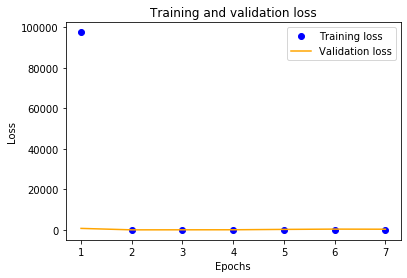

In [0]:
# let's see the training and validation loss by epoch
history_dict = history.history
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this
epochs = range(1, len(loss_values) + 1) #acc wasn't defined before
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
model.save("/content/drive/My Drive/Spring 2020 Materials/Week 2/Weather Project/Saved_Model/weather_cnn_regression_crop1.h5")

[INFO] predicting weather temperature...


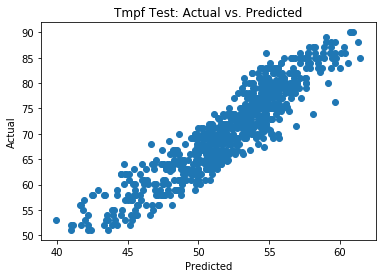

In [0]:
# make predictions on the testing data
print("[INFO] predicting weather temperature...")
preds_test = model.predict(x_test)
plt.scatter(preds_test, y_test_1)
plt.title('Tmpf Test: Actual vs. Predicted')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(result+'TMPF Test.png')

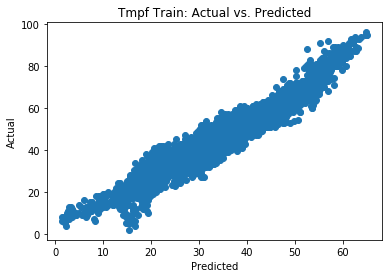

In [0]:
# actual vs. predicted on training
preds_train = model.predict(x_train)
plt.scatter(preds_train, y_train_1)
plt.title('Tmpf Train: Actual vs. Predicted')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(result+'TMPF Training.png')

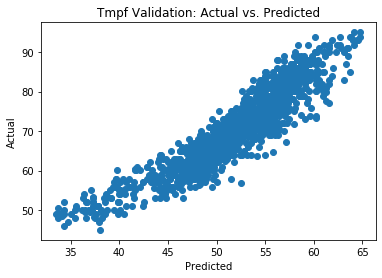

In [0]:
# actual vs. predicted on validation
preds_val = model.predict(x_val)
plt.scatter(preds_val, y_val_1)
plt.title('Tmpf Validation: Actual vs. Predicted')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(result+'TMPF Validation.png')

In [0]:
results = model.evaluate(x_test, y_test_1)
results

744/744 [==============================] - 0s 528us/sample - loss: 373.9138 - mean_absolute_error: 18.6462


[373.91375207388273, 18.64616]

In [0]:
print(type(preds_test))
print(type(y_test_1))

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [0]:
# Train dataset
# flatten the 1-D numpy array
myPreds = np.ndarray.flatten(preds_train)
myPreds = pd.DataFrame(myPreds)
myPreds.reset_index(drop=True)
myPreds.rename(columns={0: "preds_tmpf"}, inplace=True)
myPreds['Type'] = 'train'
#actual predictions
myActual = pd.DataFrame(np.array(y_train_1))
myActual.reset_index(drop=True)
myActual.rename(columns={0: "actual_tmpf"}, inplace=True)
allResults1 = pd.concat([myActual,myPreds], axis=1)
allResults1.head()

,actual_tmpf,preds_tmpf,Type
0,75.02,53.513481,train
1,73.94,55.540821,train
2,73.94,55.009678,train
3,73.94,54.154766,train
4,73.04,54.298069,train


In [0]:
# Val dataset
# flatten the 1-D numpy array
myPreds = np.ndarray.flatten(preds_val)
myPreds = pd.DataFrame(myPreds)
myPreds.reset_index(drop=True)
myPreds.rename(columns={0: "preds_tmpf"}, inplace=True)
myPreds['Type'] = 'val'
#actual predictions
myActual = pd.DataFrame(np.array(y_val_1))
myActual.reset_index(drop=True)
myActual.rename(columns={0: "actual_tmpf"}, inplace=True)
allResults2 = pd.concat([myActual,myPreds], axis=1)
allResults2.head()

,actual_tmpf,preds_tmpf,Type
0,61.025,49.558643,val
1,57.900,49.628536,val
2,57.000,48.853367,val
3,57.900,47.274044,val
4,57.900,46.223469,val


In [0]:
# Test dataset
# flatten the 1-D numpy array
myPreds = np.ndarray.flatten(preds_test)
myPreds = pd.DataFrame(myPreds)
myPreds.reset_index(drop=True)
myPreds.rename(columns={0: "preds_tmpf"}, inplace=True)
myPreds['Type'] = 'test'
#actual predictions
myActual = pd.DataFrame(np.array(y_test_1))
myActual.reset_index(drop=True)
myActual.rename(columns={0: "actual_tmpf"}, inplace=True)
allResults3 = pd.concat([myActual,myPreds], axis=1)
allResults3.head()

,actual_tmpf,preds_tmpf,Type
0,78.1,53.776817,test
1,75.0,52.906281,test
2,73.0,52.490635,test
3,71.1,52.104214,test
4,69.1,51.834141,test


In [0]:
# combine all three datasets
allResults = pd.concat([allResults1,allResults2,allResults3], axis=0)
allResults.groupby("Type").count()

,actual_tmpf,preds_tmpf
Type,,
test,744,744
train,6511,6511
val,1464,1464


#### Wind Direction Model

In [0]:
model_drct = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
model_drct.add(tf.keras.layers.Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', input_shape=(125,145,3))) 
model_drct.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model_drct.add(tf.keras.layers.Dropout(0.3))

model_drct.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model_drct.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model_drct.add(tf.keras.layers.Dropout(0.3))

# Add one more layer
#model_drct.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
#model_drct.add(tf.keras.layers.MaxPooling2D(pool_size=2))
#model_drct.add(tf.keras.layers.Dropout(0.3))

model_drct.add(tf.keras.layers.Flatten())
model_drct.add(tf.keras.layers.Dense(256, activation='relu'))
model_drct.add(tf.keras.layers.Dense(128, activation='relu'))
#model_drct.add(tf.keras.layers.Dropout(0.5))
model_drct.add(tf.keras.layers.Dense(1, activation='linear'))
model_drct.compile(optimizer='rmsprop',loss="mse", metrics=['mae'])

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', 
                   # LOOK HOW QUICK IT STOPS IF YOU DON'T USE
                   # PATIENCE - SUBJECT TO NOISE!!!
                   # will vary based on every problem you tackle
                   # try a patience of 2, 5, 10, 50, 100...
                   # what do you notice?
                   patience=5, 
                   verbose=1)

In [36]:
# train the model
print("[INFO] training model...")
history_drct = model_drct.fit(x_train, y_train_2, validation_data=(x_val, y_val_2), epochs=500, batch_size=5,verbose=1,callbacks=[es])

[INFO] training model...
Train on 6511 samples, validate on 1464 samples
Epoch 1/500
6511/6511 [==============================] - 19s 3ms/sample - loss: 92246.5590 - mean_absolute_error: 97.2689 - val_loss: 16499.2489 - val_mean_absolute_error: 111.5694
Epoch 2/500
6511/6511 [==============================] - 19s 3ms/sample - loss: 8140.2252 - mean_absolute_error: 69.3249 - val_loss: 5545.2317 - val_mean_absolute_error: 56.5455
Epoch 3/500
6511/6511 [==============================] - 19s 3ms/sample - loss: 7332.1336 - mean_absolute_error: 65.6086 - val_loss: 6277.7695 - val_mean_absolute_error: 63.1490
Epoch 4/500
6511/6511 [==============================] - 19s 3ms/sample - loss: 6950.5109 - mean_absolute_error: 63.5446 - val_loss: 5745.9056 - val_mean_absolute_error: 57.8365
Epoch 5/500
6511/6511 [==============================] - 19s 3ms/sample - loss: 6761.5807 - mean_absolute_error: 62.3580 - val_loss: 8940.5013 - val_mean_absolute_error: 78.0724
Epoch 6/500
6511/6511 [===========

In [37]:
# let's try to extract from history.history
x_drct = np.array(history_drct.epoch)
x_drct = max(x_drct)
print("We should re-run for this many epochs: ", x_drct)

We should re-run for this many epochs:  6


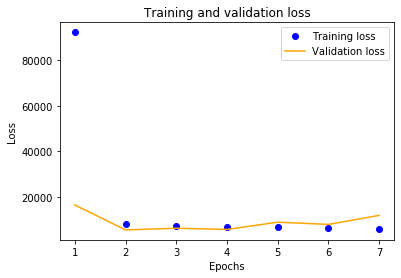

In [38]:
# let's see the training and validation accuracy by epoch
history_dict_drct = history_drct.history
loss_values = history_dict_drct['loss'] # you can change this
val_loss_values = history_dict_drct['val_loss'] # you can also change this
epochs = range(1, len(loss_values) + 1) #acc wasn't defined before
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
model_drct.save("/content/drive/My Drive/Spring 2020 Materials/Week 2/Weather Project/Saved_Model/weather_cnn_regression_crop2.h5")

[INFO] predicting wind direction...


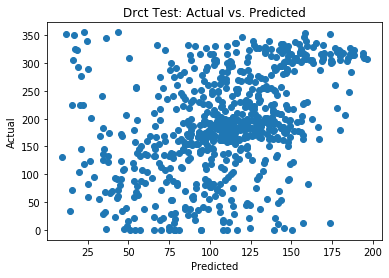

In [39]:
# make predictions on the testing data
print("[INFO] predicting wind direction...")
preds_drct3 = model_drct.predict(x_test)
plt.scatter(preds_drct3, y_test_2)
plt.title('Drct Test: Actual vs. Predicted')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(result+'DRCT Test.png')

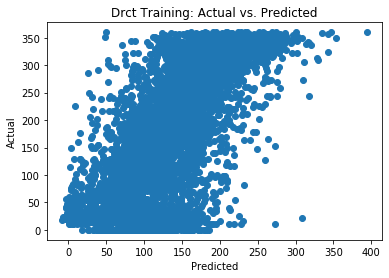

In [40]:
# actual vs. predicted on training
preds_drct1 = model_drct.predict(x_train)
plt.scatter(preds_drct1, y_train_2)
plt.title('Drct Training: Actual vs. Predicted')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(result+'DRCT Training.png')

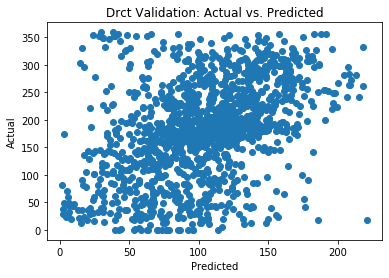

In [41]:
# actual vs. predicted on validation
preds_drct2 = model_drct.predict(x_val)
plt.scatter(preds_drct2, y_val_2)
plt.title('Drct Validation: Actual vs. Predicted')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(result+'DRCT Validation.png')

In [42]:
results_drct = model_drct.evaluate(x_test, y_test_2)
results_drct

744/744 [==============================] - 0s 542us/sample - loss: 12921.2451 - mean_absolute_error: 95.4497


[12921.245064684139, 95.44969]

In [0]:
# Train dataset
# flatten the 1-D numpy array
myPreds = np.ndarray.flatten(preds_drct1)
myPreds = pd.DataFrame(myPreds)
myPreds.reset_index(drop=True)
myPreds.rename(columns={0: "preds_drct"}, inplace=True)
myPreds['Type'] = 'train'
#actual predictions
myActual = pd.DataFrame(np.array(y_train_2))
myActual.reset_index(drop=True)
myActual.rename(columns={0: "actual_drct"}, inplace=True)
allResults_drct1 = pd.concat([myActual,myPreds], axis=1)
allResults_drct1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6511 entries, 0 to 6510
Data columns (total 3 columns):
actual_drct    6511 non-null float64
preds_drct     6511 non-null float32
Type           6511 non-null object
dtypes: float32(1), float64(1), object(1)
memory usage: 127.3+ KB


In [0]:
# Val dataset
# flatten the 1-D numpy array
myPreds = np.ndarray.flatten(preds_drct2)
myPreds = pd.DataFrame(myPreds)
myPreds.reset_index(drop=True)
myPreds.rename(columns={0: "preds_drct"}, inplace=True)
myPreds['Type'] = 'val'
#actual predictions
myActual = pd.DataFrame(np.array(y_val_2))
myActual.reset_index(drop=True)
myActual.rename(columns={0: "actual_drct"}, inplace=True)
allResults_drct2 = pd.concat([myActual,myPreds], axis=1)
allResults_drct2.head()

,actual_drct,preds_drct,Type
0,203.636364,101.916916,val
1,113.333333,88.697388,val
2,205.384615,105.526321,val
3,229.090909,119.205971,val
4,120.000000,110.930000,val


In [0]:
# Test dataset
# flatten the 1-D numpy array
myPreds = np.ndarray.flatten(preds_drct3)
myPreds = pd.DataFrame(myPreds)
myPreds.reset_index(drop=True)
myPreds.rename(columns={0: "preds_drct"}, inplace=True)
myPreds['Type'] = 'test'
#actual predictions
myActual = pd.DataFrame(np.array(y_test_2))
myActual.reset_index(drop=True)
myActual.rename(columns={0: "actual_drct"}, inplace=True)
allResults_drct3 = pd.concat([myActual,myPreds], axis=1)
allResults_drct3.head()

,actual_drct,preds_drct,Type
0,186.666667,139.327225,test
1,181.538462,123.422653,test
2,196.923077,130.841827,test
3,154.615385,105.469078,test
4,143.076923,96.396080,test


In [0]:
# combine all three datasets
allResults_drct = pd.concat([allResults_drct1,allResults_drct2,allResults_drct3], axis=0)
allResults_drct.groupby("Type").count()

,actual_drct,preds_drct
Type,,
test,744,744
train,6511,6511
val,1464,1464
